# Master Thesis Notebook

## Setup

In [1]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Choosing the variogram model (field A)

A variogram, also known as a semivariogram, is a measure of spatial variability or spatial dependence of a variable across different locations in a spatial domain.
It quantifies how the variance of a variable changes with distance and direction.
The variogram is crucial in kriging because it defines the spatial structure or dependence of the variable being estimated.

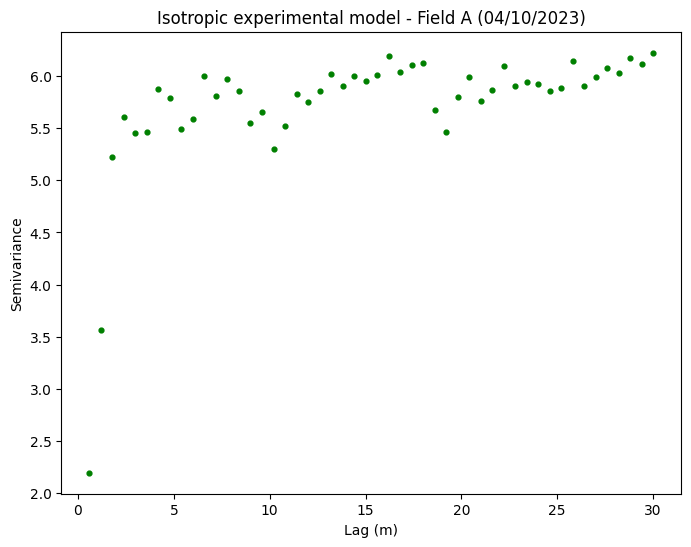

In [2]:
experimental_vario_a = Variogram(resolution=1, field_letter="A", sample_number=6)

experimental_vario_a.determ_experimental_vario() ;
# ; hide output of the cell

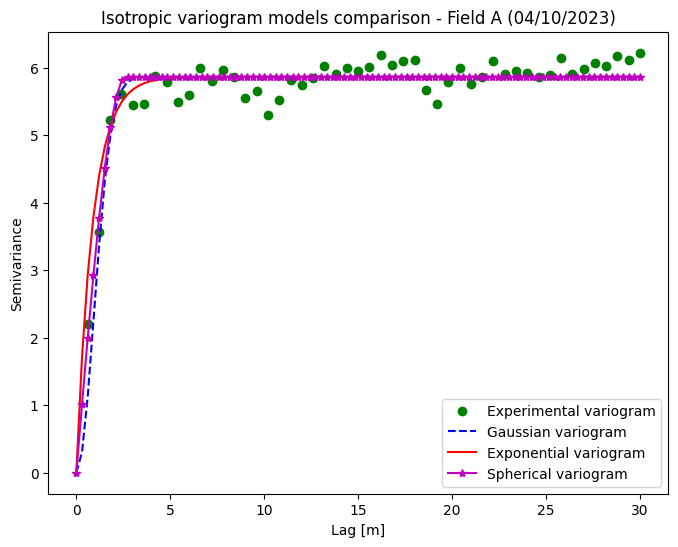

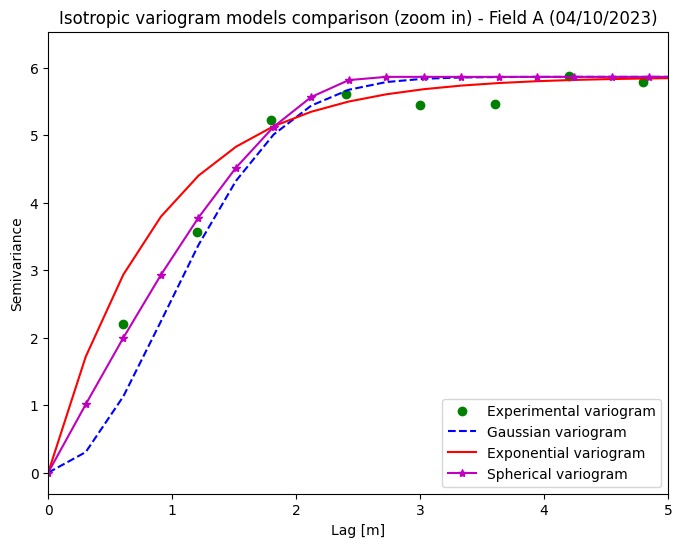

In [3]:
experimental_vario_a.fit_models()

### Choosing the variogram model (field B)

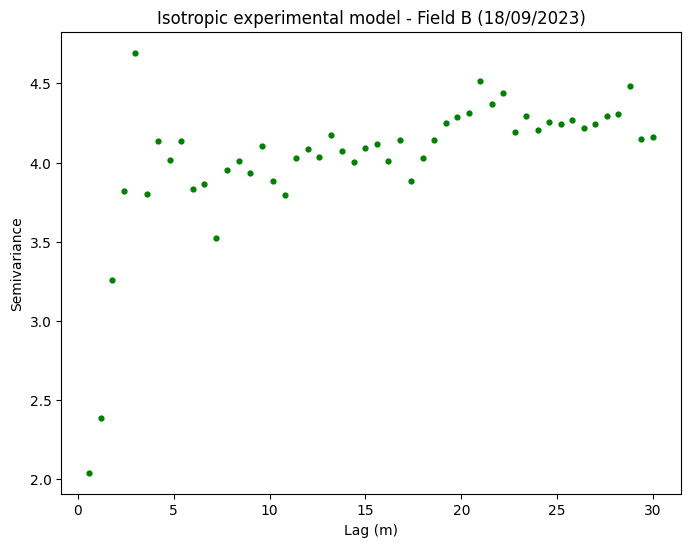

In [4]:
experimental_vario_b = Variogram(resolution=1, field_letter="B", sample_number=5)

experimental_vario_b.determ_experimental_vario() ;

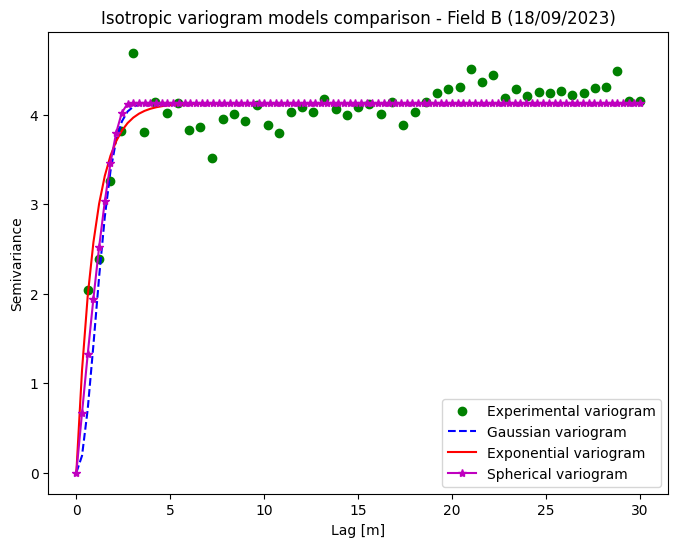

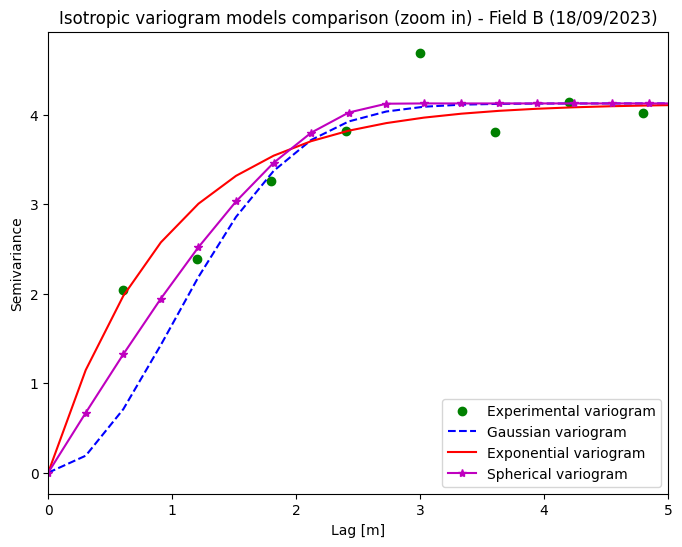

In [5]:
experimental_vario_b.fit_models()

### Raw data to Kriged data

In [3]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=6)  # Sample number [0-11] # A/B
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=5)  # Sample number [0-11] # A/B

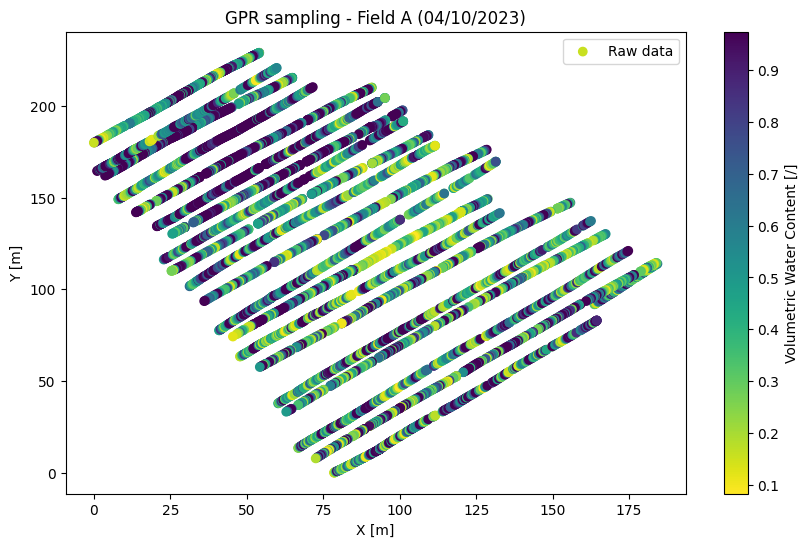

In [7]:
# Raw Sample
gpr_a.plot_raw_data()

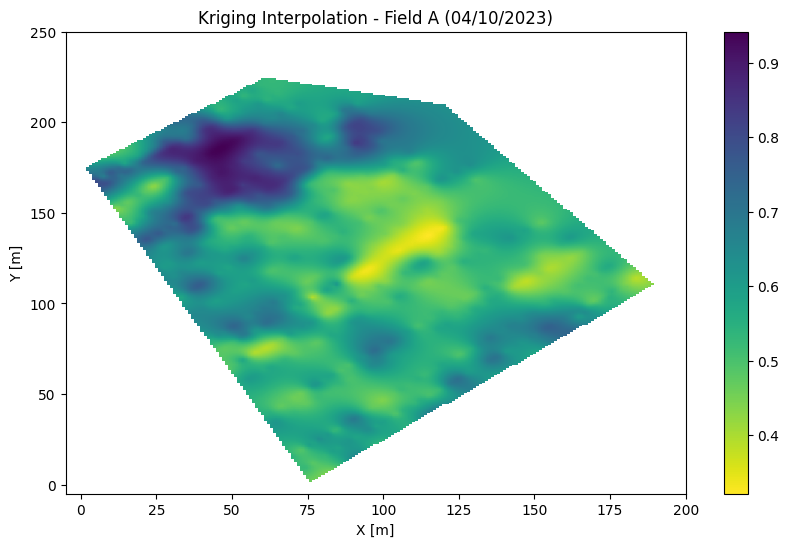

In [8]:
gpr_a.kriging(plot=True)

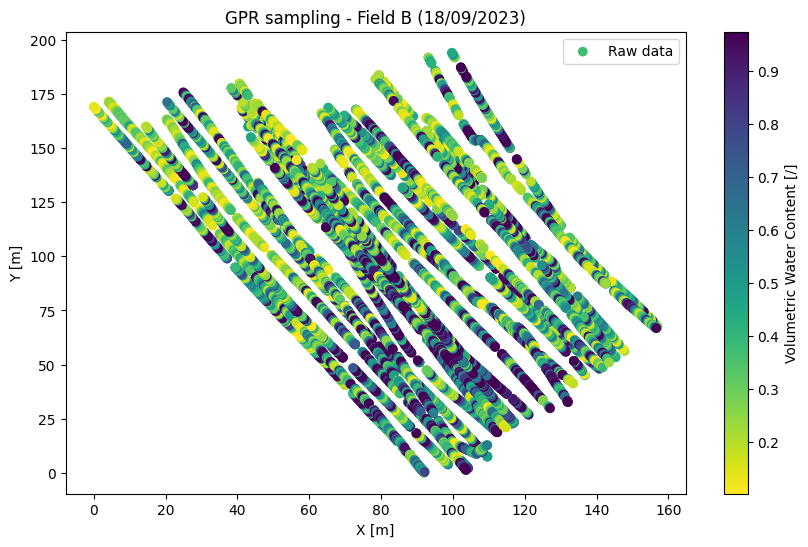

In [3]:
gpr_b.plot_raw_data()

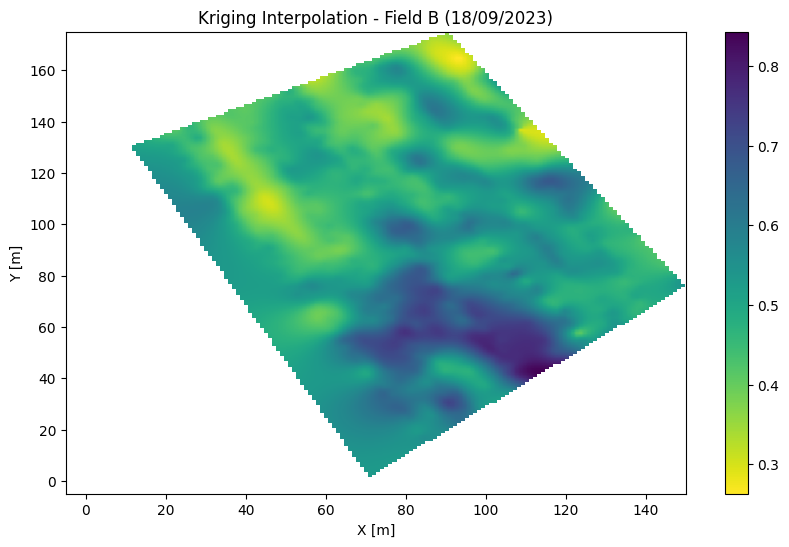

In [4]:
gpr_b.kriging(plot=True)

### GPR derived VWC evolution

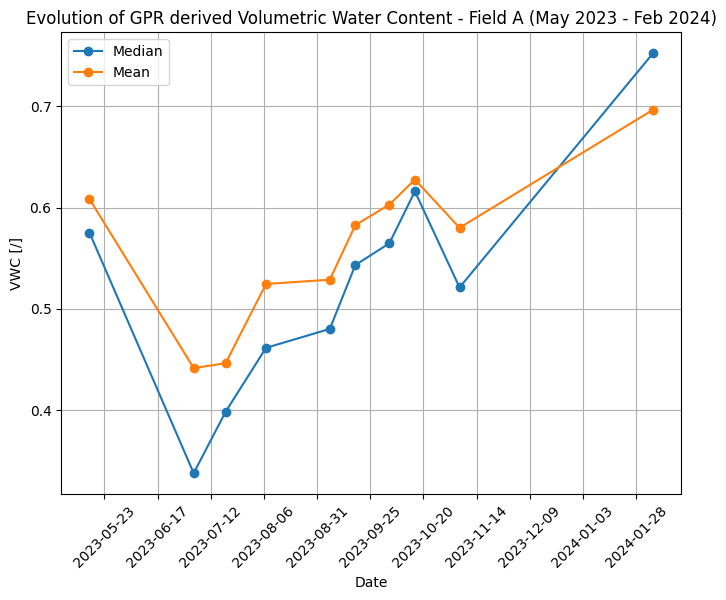

([0.6085552944692754,
  0.44139795094394046,
  0.4462243677504228,
  0.5245480527646154,
  0.5287835776572668,
  0.5827594197752047,
  0.60296068598107,
  0.6278072904648803,
  0.5800869101363354,
  0.6968213531823204],
 [0.5752936,
  0.33754477,
  0.39821214,
  0.46140056,
  0.48014645,
  0.54326926,
  0.56476229,
  0.61611834,
  0.52111085,
  0.75270779])

In [4]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

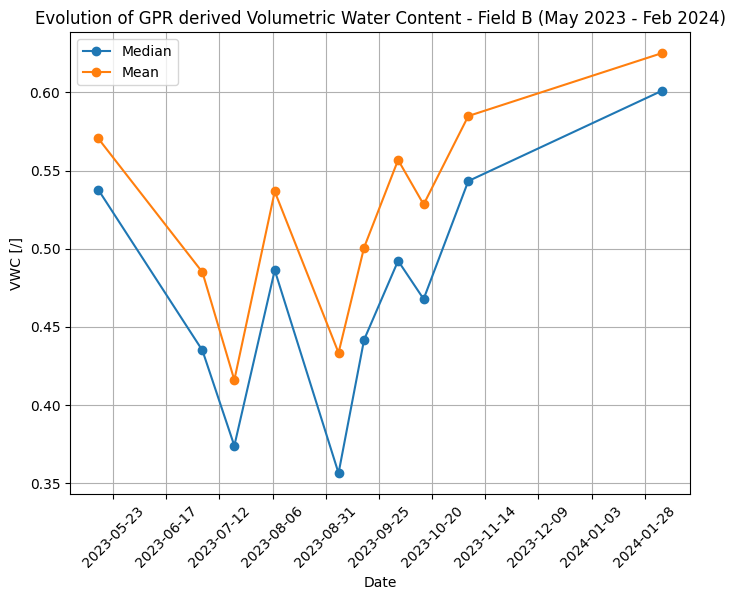

([0.5705958009840272,
  0.48490636860588526,
  0.4159073876134969,
  0.5365923222105704,
  0.4333052906583408,
  0.5007107854937718,
  0.556792551812546,
  0.5283072766890595,
  0.5849051981224489,
  0.6251475836511157],
 [0.53779752,
  0.43483551,
  0.37380929,
  0.4862126,
  0.35627034,
  0.44167178,
  0.49219849,
  0.46774755,
  0.54326926,
  0.60104858])

In [5]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Zonal tendencies (field A)

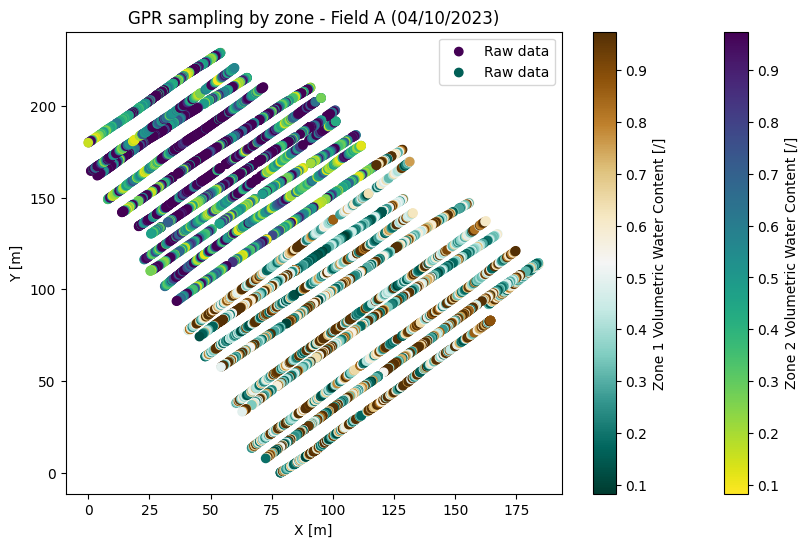

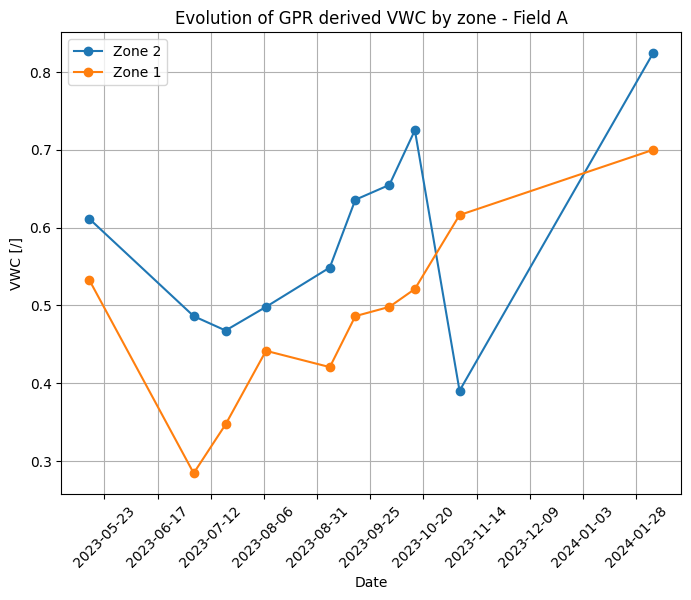

In [6]:
gpr_a.zonal_check()

### Zonal tendencies (field B)

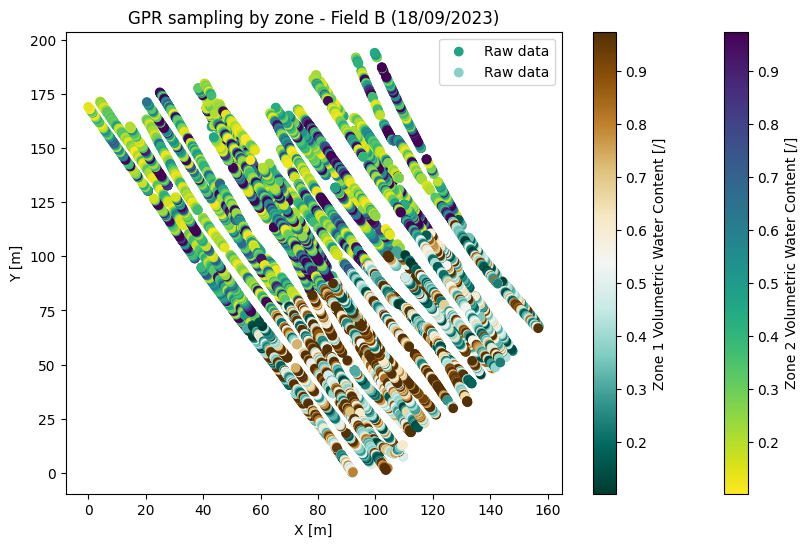

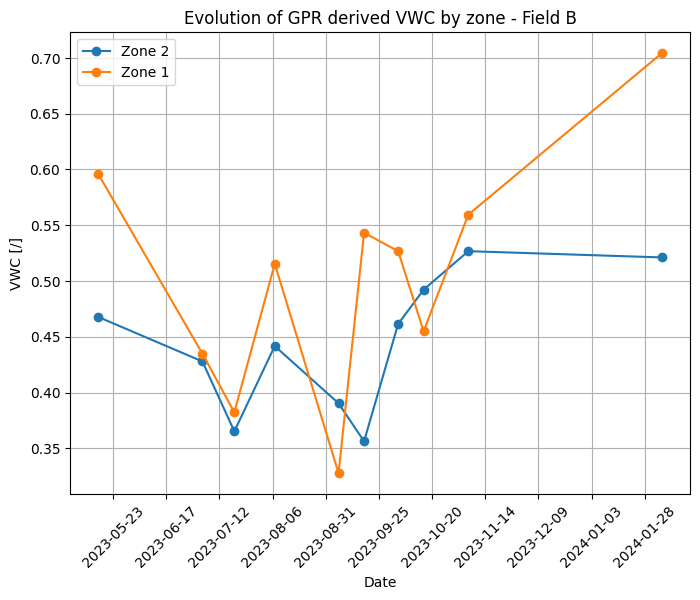

In [7]:
gpr_b.zonal_check()

## Terros Comparison

### Field A

y = 0.23695683637126294x + 0.6948247007678722


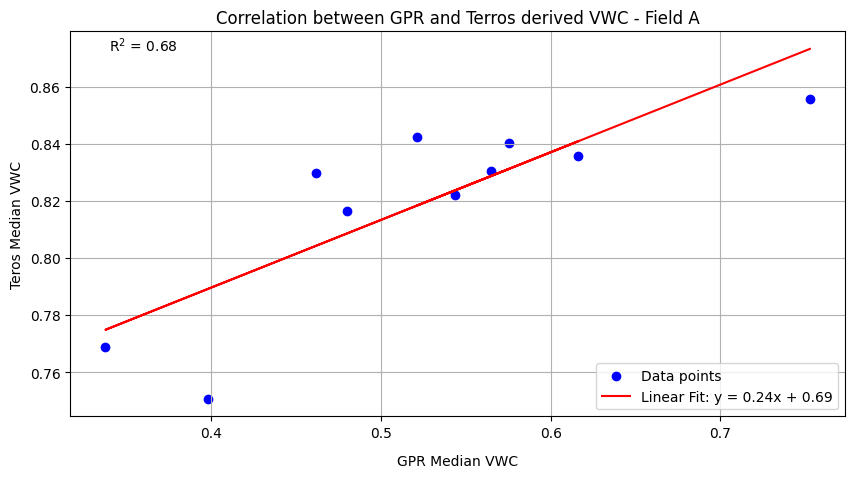

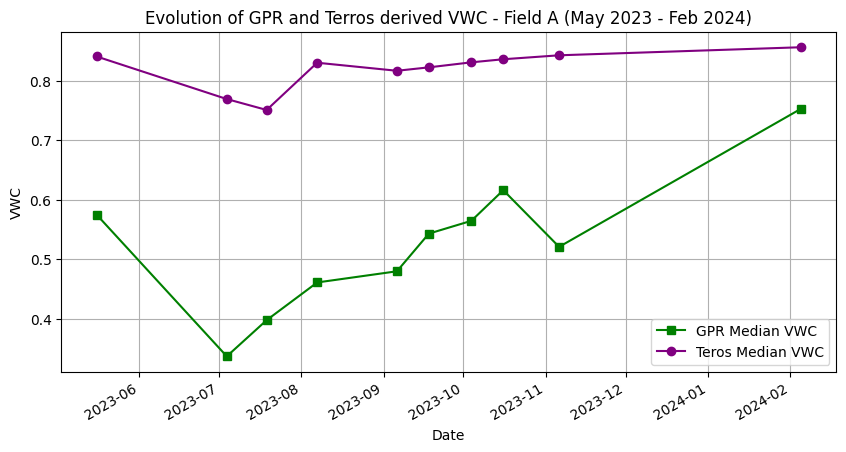

In [2]:
Gpr_data = GprAnalysis()
Gpr_data.correlate_gpr_terros()

### Field B

y = 0.32528506967310905x + 0.6652224963790402


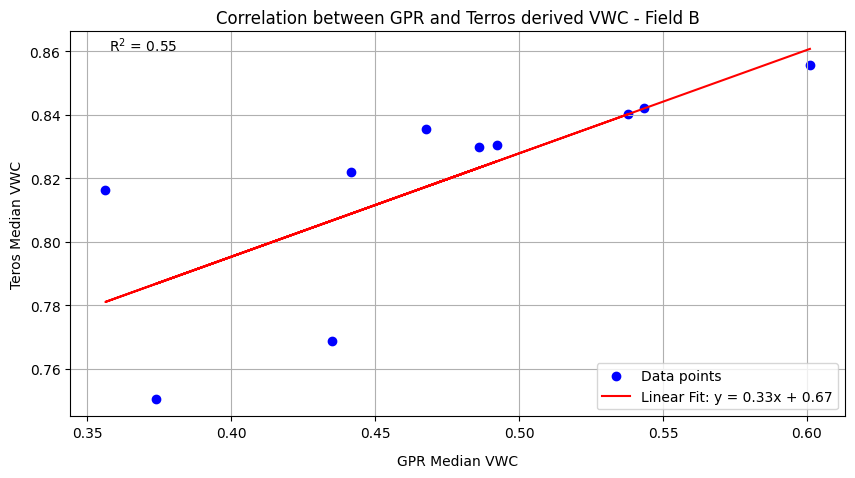

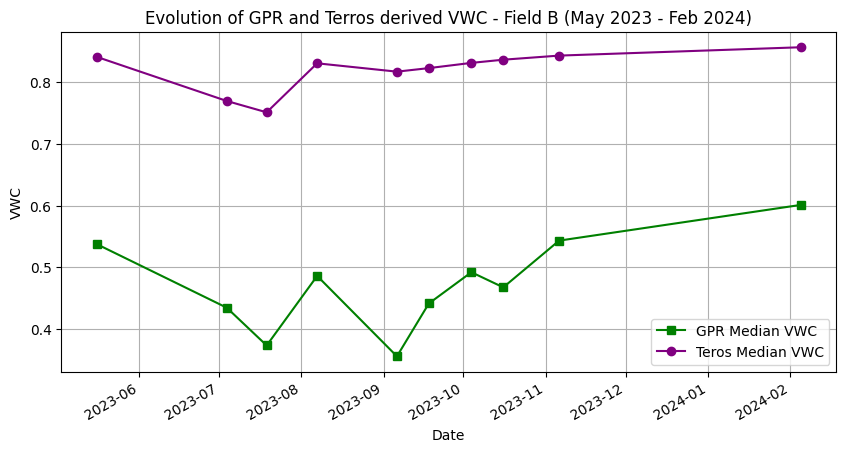

In [6]:
Gpr_data = GprAnalysis(field_letter="B")
Gpr_data.correlate_gpr_terros()

## TDR Verification

### Zonal Comparison - Field A

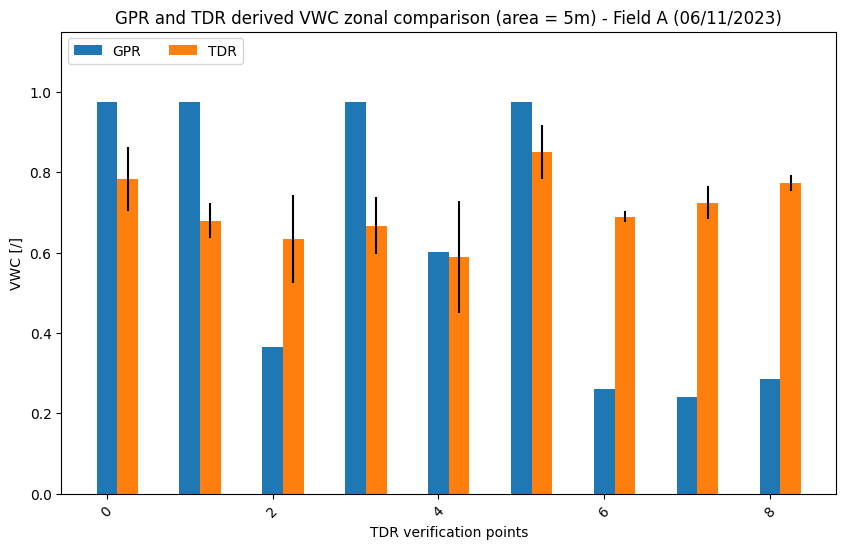

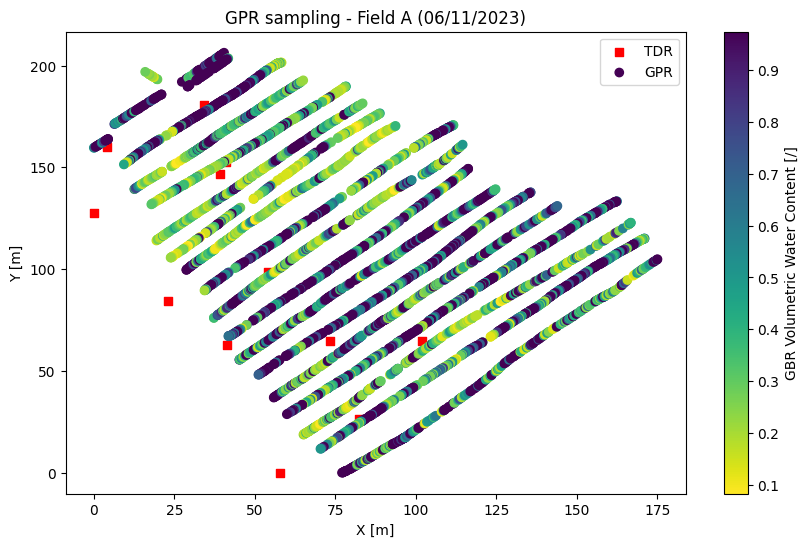

In [8]:
GprAnalysis(field_letter="A", sample_number=8).tdr_verification(5)

### Correlation - Field A

y = 0.3417614011573552x + 0.481956643983769


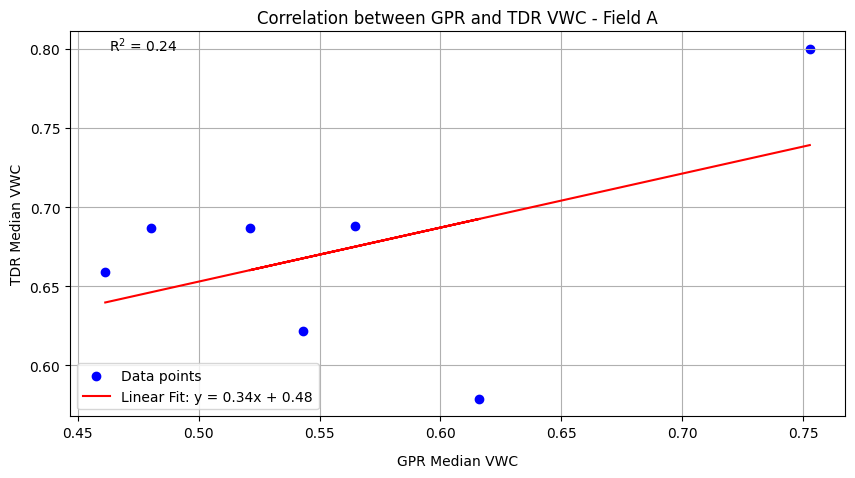

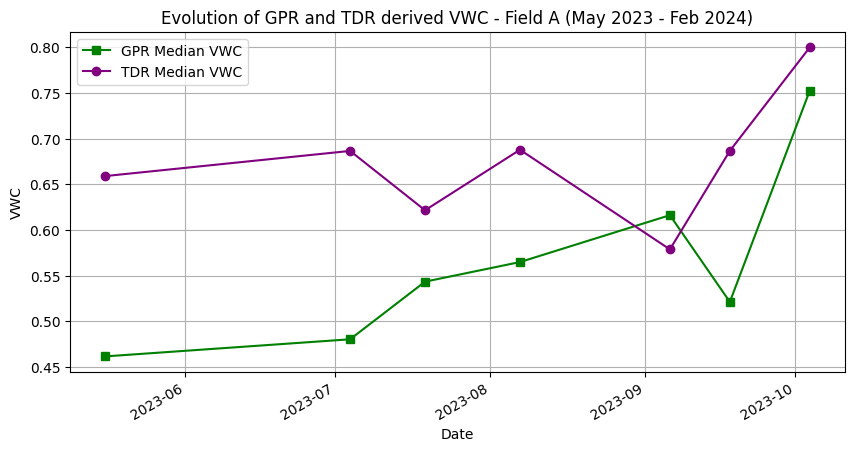

In [7]:
GprAnalysis(field_letter="A", sample_number=8).correlate_gpr_tdr()

### Zonal Comparison - Field B

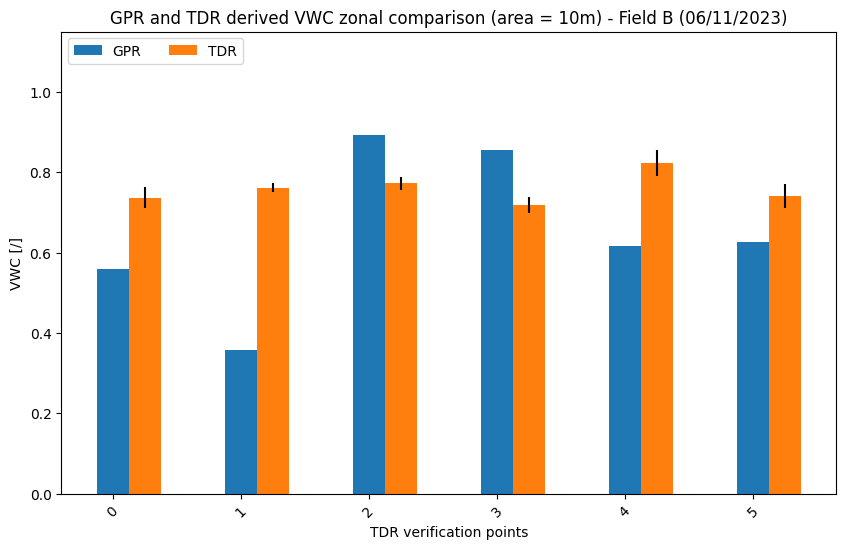

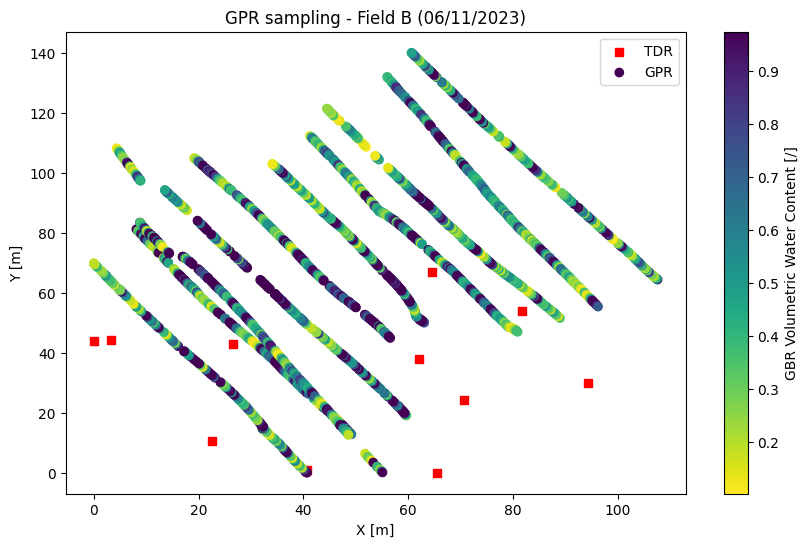

In [4]:
GprAnalysis(field_letter="B", sample_number=8).tdr_verification(10)

### Correlation - Field B

y = 0.5297966422266064x + 0.4626073531406159


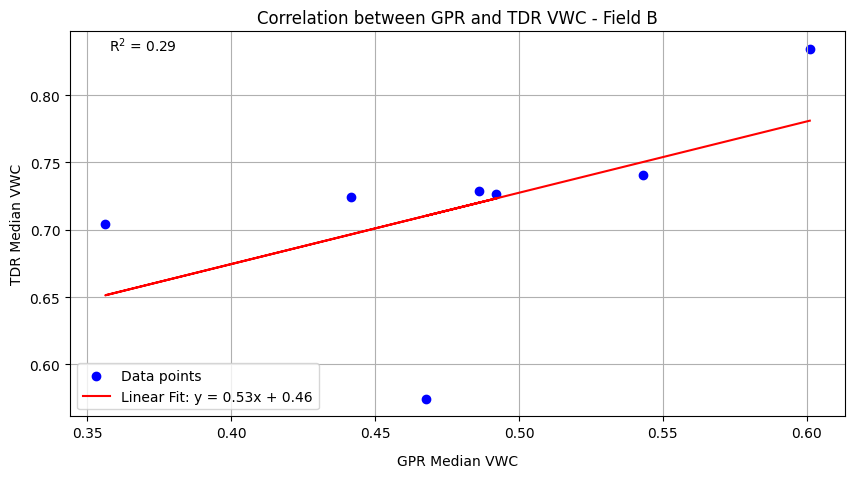

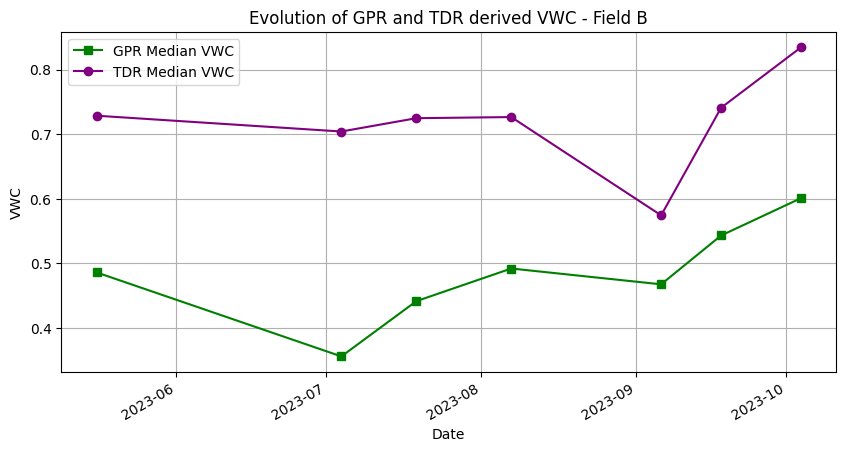

In [4]:
GprAnalysis(field_letter="B", sample_number=8).correlate_gpr_tdr()

## Rainfall Analysis

d:\Coding\Python\Master-Thesis\classes.py:731: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


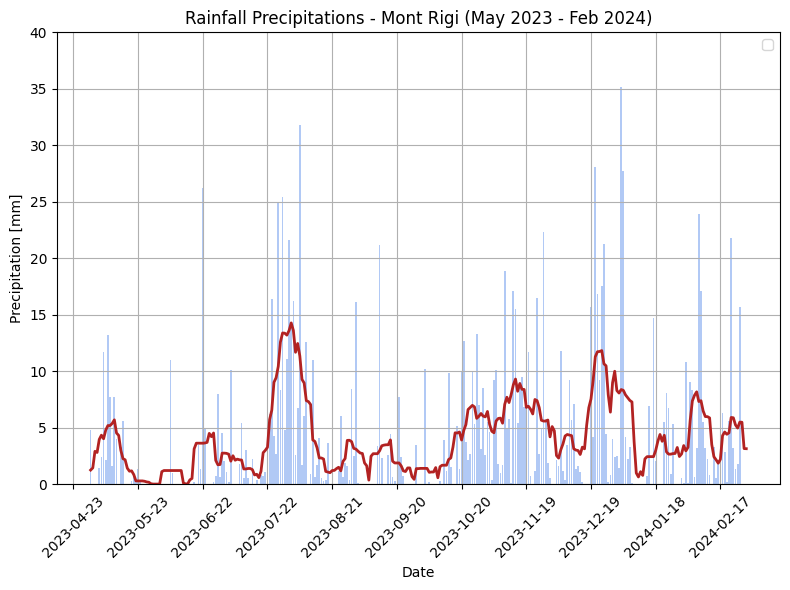

In [2]:
rf_mr = Rainfall()
rf_mr.plot_data()

## VWC continuous Analysis

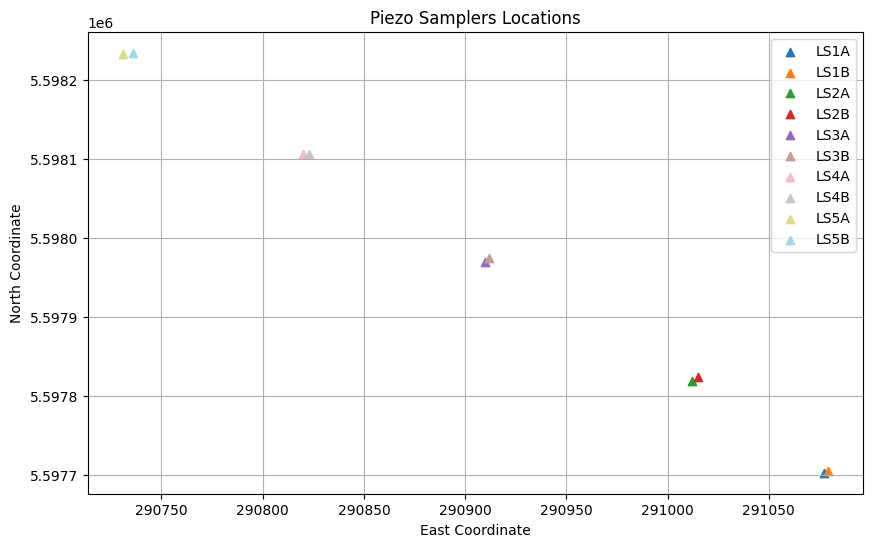

In [11]:
teros = Teros()
teros.plot_piezo_sampler_locations()

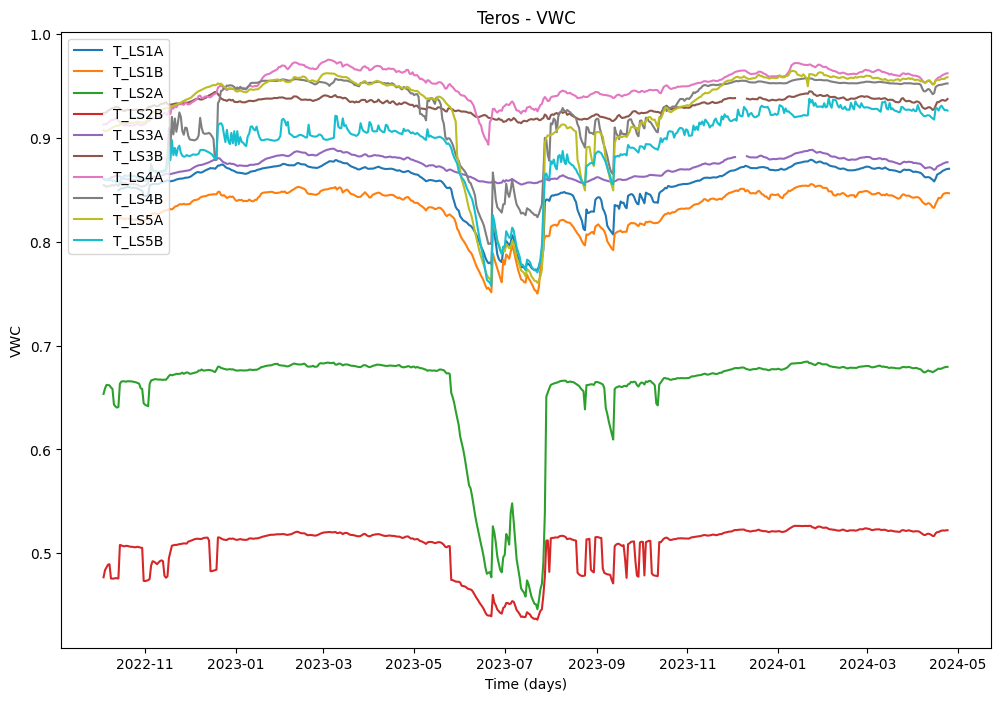

In [12]:
teros.plot_vwc_evolution()

## Water table depth Analysis

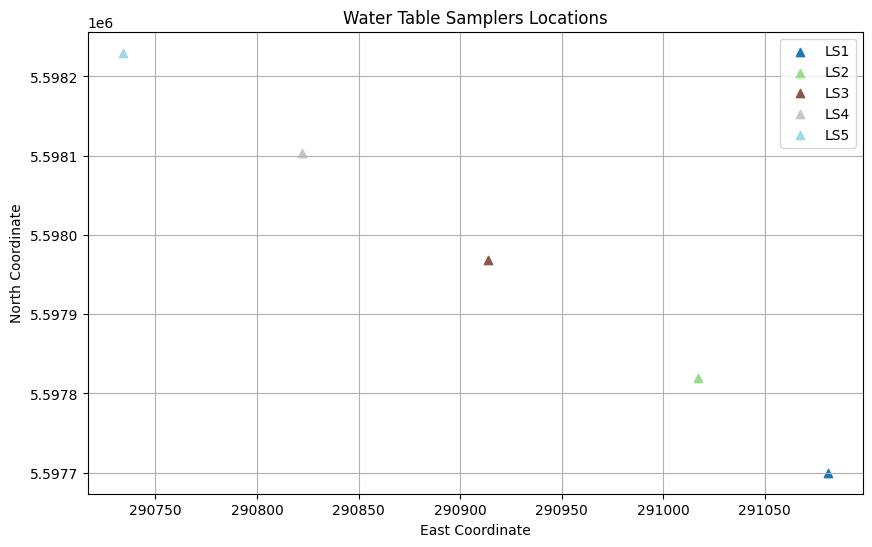

In [13]:
wt = WaterTable()
wt.plot_wt_sampler_locations()

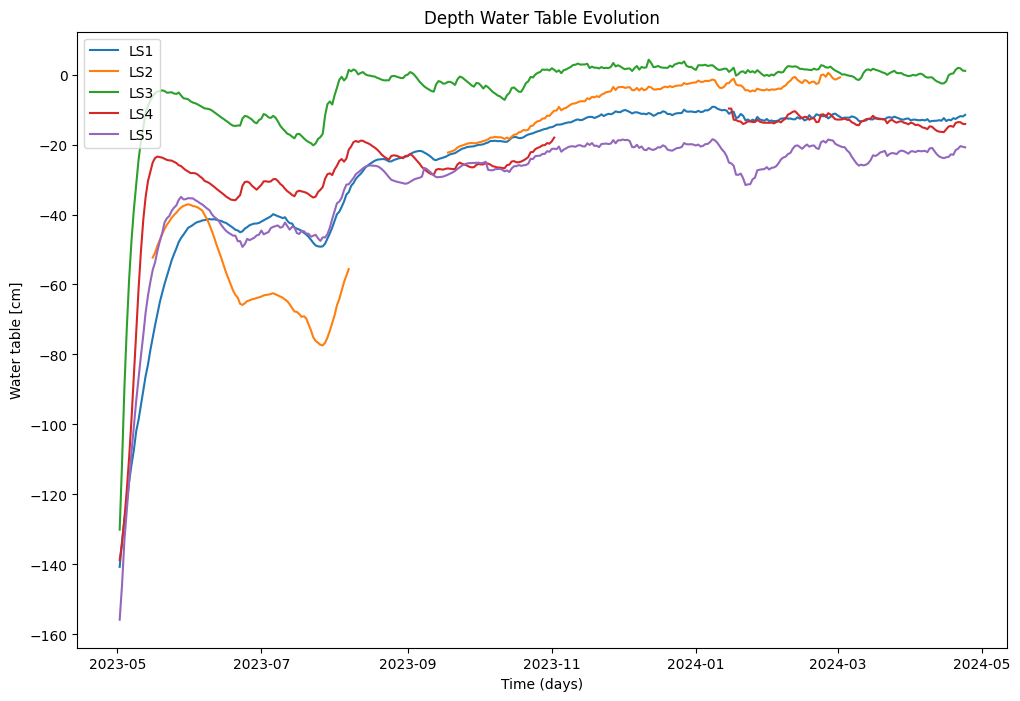

In [14]:
wt.plot_wt_evolution()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


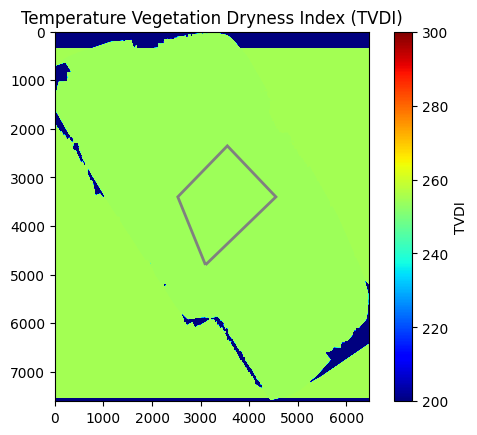

In [15]:
multi_a = MultispecAnalysis(field_letter="A")

multi_a.calculate_tvdi()

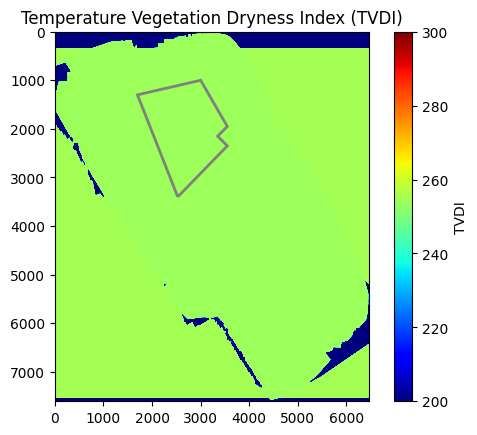

In [16]:
multi_b = MultispecAnalysis(field_letter="B")

multi_b.calculate_tvdi()